[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zhimingkuang/Harvard-AM-115/blob/main/05_data_fitting/fit_yeast_ode.ipynb)

In [ ]:
# If running locally, you may need to install the following packages
# Uncomment any needed and run this block (change pip3 with conda if you use Anaconda)
# !pip3 install numpy
# !pip3 install pandas
# !pip3 install xlrd
# !pip3 install matplotlib
# !pip3 install scipy
# !pip3 install statsmodels

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import chisquare
from statsmodels.api import qqplot

### This code gives an example of how to read in the csv/Excel data and a template for the exercise of modeling running


If working within Google Colab, run the following cell to clone the Github repo to access the data. If not can just skip to the next cell.

In [ ]:
# Load in data if run on Google Colab
!git clone https://github.com/zhimingkuang/Harvard-AM-115.git
%cd Harvard-AM-115/05_data_fitting

In [3]:
# Data import and setup
# Give the location of the file, replace with yours
loc = ('carlson_yeast_data.xls')

# Read in Excel, set up Series
yeast_data = pd.read_excel(loc, index_col=None, header='infer')

# Separate time and amount into separate Series
# Make sure to start at hours = 1 for the data fitting
time = yeast_data.iloc[1:,0]
amount = yeast_data.iloc[1:,1]

# Initial guess of the parameters
# We have normalized the parameters so they are of order 1
beta0 = [1,1]

In [4]:
# Define the ODE to be solved
def f(t, y, r, K):
    """Define the logistic differential equation

    Args:
        t (float): time
        y (numpy.ndarray): population
        r (numpy.float64): growth rate
        K (numpy.int64): carrying capacity

    Returns:
        numpy.ndarray: differential equation
        
    """
    
    ydot = r*y*(1-y/K)
    
    return ydot

In [5]:
# Define the curve to be fitted as a function of parameters and indepenent variable
def ode45_logistic(t, beta0, beta1):
    """Define the logistic differential equation

    Args:
        t (numpy.ndarray): time
        beta0 (numpy.int64): first unknown parameter, growth rate
        beta1 (linumpy.int64st): second unknown parameter, carrying capcity

    Returns:
        numpy.ndarray: y-values after data fitting
        
    """
    
    # Unpack parameters
    y0 = 9.6 # initial yeast population, assumed to be known to simplify the plots
    r = beta0*0.5 # growth rate, normalized so beta is of order 1
    K = beta1*600 # carrying capacity, normalized so beta is of order 1
    t0 = 0 # initial time     
    
    # Solve the logistic ODE with RK45
    sol = solve_ivp(lambda t,y: f(t,y,r,K), [t0,max(t)], [y0], max_step=1.0, rtol=1e-12)
    # Unpack solution
    t, y = sol.t, sol.y
    
    # Do the interpolation, which creates a function yfit
    yfit = interp1d(t,y[0,:])
    y_new = yfit(time)
    
    return y_new

In [6]:
# Estimate the beta parameters
params, pcov = curve_fit(ode45_logistic, time, amount, p0=beta0)

print(f"Estimated beta parameters\n beta0: {params[0]}\n beta1: {params[1]}")

# Find the predicted values given the best-fit beta parameters
yfit = ode45_logistic(time, params[0], params[1])

Estimated beta parameters
 beta0: 1.0811190059871583
 beta1: 1.1067023577878954


In [7]:
# Customize for matplotlib
# If interested in the matplotlib object hierarchy, check: https://realpython.com/python-matplotlib-guide/
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['mathtext.default'] = 'regular'
# Change font size: http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20

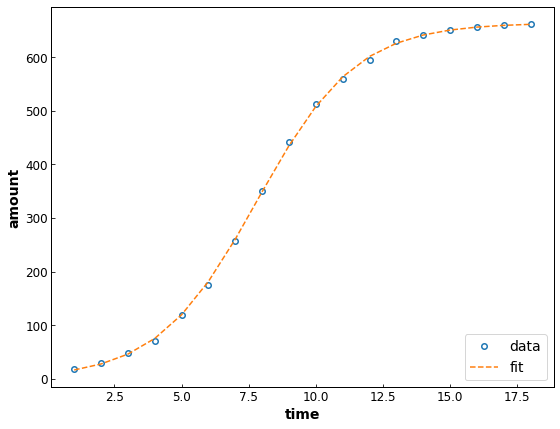

In [8]:
# Plot solution
fig, ax = plt.subplots(1,1,figsize=(9,7))

plt.plot(time, amount, 'o', linewidth=1.5, mfc='none', ms=5.5, mew=1.5, label='data')
plt.plot(time, yfit, '--', linewidth=1.5, mfc='none', ms=5.5, mew=1.5, label='fit')

# Set axes labels and legends
ax.set_xlabel('time')
ax.set_ylabel('amount')
ax.legend(loc='lower right')

plt.show()

### Our work is not done!
Need to test whether the residual is consistent with our assumptions. Use chi-square goodness of fit.

If we know the measurement precision, we can compare MSE to the expected MSE to test the goodness of fit. While don't know the measurement precision here, we can still test if the residuals is consistent with a normal distribution with  the mean and standard deviation estimated from the residuals.

In [9]:
# Compute the residuals
residuals = amount - ode45_logistic(time, *params)

# Perform the chi-square goodness of fit test, using the predicted data and the actual data
# Need to normalize both inputs due to this change: https://github.com/scipy/scipy/issues/13362
observe = ode45_logistic(time, *params)
expected = amount
stat, p = chisquare(observe, expected)

print(f'Chi-square test statistics: {stat}, p-value: {p}')

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.0005472343100901218

The null hypothesis:  that the residuals are drawn from a normal distribution with the mean and standard deviation estimated from the residuals.

The smaller the p-value: indicates greater confidence in rejecting the null hypothesis.

h=0 means we cannot reject the null hypothesis that R is drawn from a normal distribution with the mean and standard deviation estimated from the residuals p is the p-value. Smaller p-value indicates greater confidence in rejecting the null hypothesis.

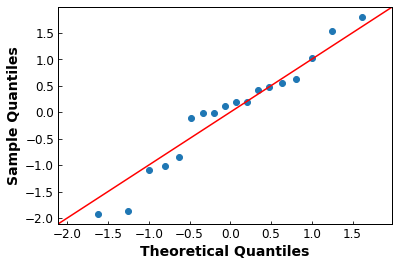

In [10]:
# Plot solution
# fig, ax = plt.subplots(1,1,figsize=(9,7))

# A more visual way to look at the results with quantile quantile plot
fig = qqplot(residuals, fit=True, line="45")

# # Set axes labels and legends
# ax.set_xlabel('standard normal quantiles')
# ax.set_ylabel('quantiles of input sample')
# ax.legend(loc='lower right')
# ax.set_title('QQ plot of sample data v.s. standard normal')

plt.show()